# bbands

- 가격의 이동평균을 기준 가격으로 삼을 때 가격의 예상 변동성
- 가격이 밴드 바깥으로 벗어날 때 돌파/추세 시그널 또는 과매수/과매도 평균 회귀 시그널

In [1]:
import pandas as pd
from pandas_datareader import data
import statistics as stats
import math as math
import matplotlib.pyplot as plt

In [2]:
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data = goog_data2.tail(620)

close = goog_data['Close']

In [3]:
time_period = 20  # 중앙 밴드 SMA의 히스토리 기간 길이
stdev_factor = 2  # 위/아래 밴드를 위한 표준편차 스케일 팩터
history = []      # 단순 이동평균을 계산하기 위한 가격 히스토리
sma_values = []   # 시각화를 위한 이동평균 가격
upper_band = []   # 위 밴드 값
lower_band = []   # 아래 밴드 값

for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # 'TIME PERIOD' 개수까지 가격 관찰 수 유지하고자 함
    del (history[0])

  sma = stats.mean(history)
  sma_values.append(sma)    # 중앙 밴드의 단순이동평균
  variance = 0              # 분산은 표준편차의 제곱
  for hist_price in history:
    variance = variance + ((hist_price - sma) ** 2) 

  stdev = math.sqrt(variance / len(history)) # 표준편차를 구하고자 제곱근 사용

  upper_band.append(sma + stdev_factor * stdev)
  lower_band.append(sma - stdev_factor * stdev)


In [4]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(MiddleBollingerBand20DaySMA=pd.Series(sma_values, index=goog_data.index))
goog_data = goog_data.assign(UpperBollingerBand20DaySMA2StdevFactor=pd.Series(upper_band, index=goog_data.index))
goog_data = goog_data.assign(LowerBollingerBand20DaySMA2StdevFactor=pd.Series(lower_band, index=goog_data.index))

close_price = goog_data['ClosePrice']
mband = goog_data['MiddleBollingerBand20DaySMA']
uband = goog_data['UpperBollingerBand20DaySMA2StdevFactor']
lband = goog_data['LowerBollingerBand20DaySMA2StdevFactor']

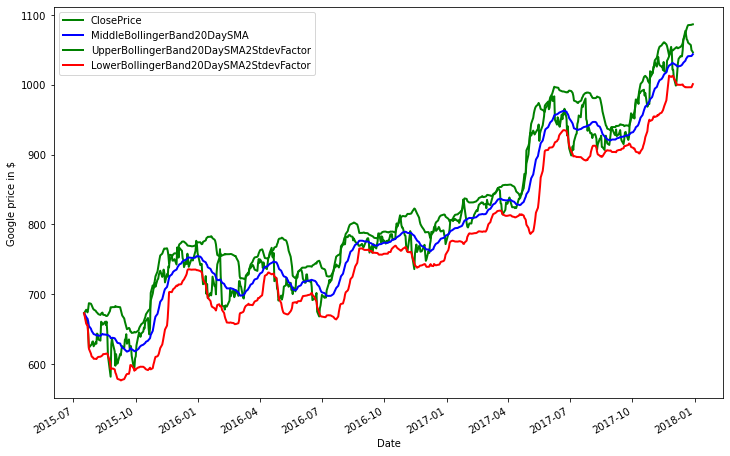

In [6]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
mband.plot(ax=ax1, color='b', lw=2., legend=True)
uband.plot(ax=ax1, color='g', lw=2., legend=True)
lband.plot(ax=ax1, color='r', lw=2., legend=True)
plt.show()